This is a script where we generates multiple versions of models and compare their perfromance.
To generate and save the final model, use another script named "run_modeling_main.ipynb"

In [5]:
import numpy as np
import pandas as pd
import random
import torch.nn as nn

import utils
import modeling_utils as modeling
from importlib import reload

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import RocCurveDisplay, roc_curve, auc
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.experimental import enable_hist_gradient_boosting
from scipy import interp

In [2]:
local_folder = "./data/"
truthset_positive = f"{local_folder}/truthset_positives.240227.tsv"
truthset_negative = f"{local_folder}/truthset_negatives.240227.tsv"
label_columns = ["score.(iPSC)", "score.(MB1)", "score.(Gaertner)"]

labels = {}
utils.read_labels(data_path=truthset_negative, labels=labels, label_columns=label_columns)
utils.read_labels(data_path=truthset_positive, labels=labels, label_columns=label_columns)

('chr4', '164877331', '164879008', '+', '164877331-164877407|164878919-164879008')


In [3]:
len(labels)

4874

In [7]:
pd.DataFrame(labels).T

score.(iPSC)  \
chr1 26280140  26281123  + 26280140-26280203|26280764-26280932|26281057-26...             0   
     74763918  74764113  + 74763918-74764113                                              0   
     23779900  23787376  + 23779900-23779941|23785674-23785779|23786314-23...             0   
     86880689  86914120  - 86880689-86880725|86903280-86903448|86914027-86...             0   
     1392781   1393451   - 1392781-1392803|1393395-1393451                                0   
...                                                                                     ...   
chr4 30721175  30721610  + 30721175-30721610                                              0   
chr5 6633524   6644888   + 6633524-6633869|6644807-6644888                                1   
chr7 92057696  92057930  + 92057696-92057930                                              0   
chr8 28701519  28701648  + 28701519-28701648                                              2   
     144509076 144509445 + 144509076-144509445                                            3   

                                                                               score.(MB1)  \
chr1 26280140  26281123  + 26280140-26280203|26280764-26280932|26281057-26...            0   
     74763918  74764113  + 74763918-74764113                                             0   
     23779900  23787376  + 23779900-23779941|23785674-23785779|23786314-23...            0   
     86880689  86914120  - 86880689-86880725|86903280-86903448|86914027-86...            0   
     1392781   1393451   - 1392781-1392803|1393395-1393451                               0   
...                                                                                    ...   
chr4 30721175  30721610  + 30721175-30721610                                             0   
chr5 6633524   6644888   + 6633524-6633869|6644807-6644888                               0   
chr7 92057696  92057930  + 92057696-92057930                                             0   
chr8 28701519  28701648  + 28701519-28701648                                             0   
     144509076 144509445 + 144509076-144509445                                           0   

                                                                               score.(Gaertner)  
chr1 26280140  26281123  + 26280140-26280203|26280764-26280932|26281057-26...                 0  
     74763918  74764113  + 74763918-74764113                                                  0  
     23779900  23787376  + 23779900-23779941|23785674-23785779|23786314-23...                 0  
     86880689  86914120  - 86880689-86880725|86903280-86903448|86914027-86...                 0  
     1392781   1393451   - 1392781-1392803|1393395-1393451                                    0  
...                                                                                         ...  
chr4 30721175  30721610  + 30721175-30721610                                                  0  
chr5 6633524   6644888   + 6633524-6633869|6644807-6644888                                    1  
chr7 92057696  92057930  + 92057696-92057930                                                  1  
chr8 28701519  28701648  + 28701519-28701648                                                  2  
     144509076 144509445 + 144509076-144509445                                                2  

[4874 rows x 3 columns]

In [8]:
group_names = ["iPSC", "Gaertner", "MB1"]
experiment_groups = {}
for group_name in group_names:
    experiment_groups[group_name] = []
    for line in open(f"{local_folder}/{group_name}.txt"):
        experiment_groups[group_name].append(line.strip())

features = {}
for group_name, experiment_name_list in experiment_groups.items():
    features[group_name] = []
    for experiment_name in experiment_name_list:
        #utils.download_feature_set(
        #    experiment_name=experiment_name,
        #    local_folder="./data/")
        utils.read_features(
            data_path=f"{local_folder}/{experiment_name}_orf_features.csv",
            features = features[group_name],
            labels=labels,
            label_name=f"score.({group_name})")
        #utils.remove_local_copy(experiment_name, local_folder)

206 2998
206 2992
204 2942
211 3025
217 3058
213 3051
211 3061
213 3066
217 3198
216 3232
218 3234
217 3250
216 3248
215 3263
216 3261
215 3271
217 3273
219 3240
218 3212
220 3259
220 3253
221 3255
220 3243
216 3141
216 3192
217 3203
219 3187
217 3228
225 3218
222 3235
222 3224
221 3256
221 3252
161 2104
157 1791
160 1927


In [10]:
def run(feature_list):
    validation_chroms = ["chr1", "chr7", "chr14", "chr21"]
    test_chroms = ["chr2", "chr8", "chr15", "chr22"]
    
    (training_data_x, training_data_y,
     validation_data_x, validation_data_y,
     test_data_x, test_data_y) = utils.get_dataset(feature_list, validation_chroms, test_chroms)
    model = modeling.train_model(
        training_data_x, training_data_y, validation_data_x, validation_data_y)
    return model

def evaluate(model, feature_list, experiment_name):
    validation_chroms = ["chr1", "chr7", "chr14", "chr21"]
    test_chroms = ["chr2", "chr8", "chr15", "chr22"]
    
    (_, _, _, _, test_data_x, test_data_y) = utils.get_dataset(feature_list, validation_chroms, test_chroms)
    modeling.evaluate_model(nn.BCELoss(), model, test_data_x, test_data_y,
                            plot=True, plot_folder="./plots", experiment_name=experiment_name)

# generate models with different training data combinations

In [11]:
feature_list = features["Gaertner"] + features["iPSC"]
random.shuffle(feature_list)
model_Gaertner_iPSC = run(feature_list)

input_size: 27
torch.Size([72284, 27]) torch.Size([72284])
Epoch 1, Training Loss: 0.18993943882858857
Validation Loss: 0.15788245500686268
Validation ROC-AUC: 0.8974364975171559
Validation PR-AUC: 0.5731877169048067
Epoch 2, Training Loss: 0.12814696941079687
Validation Loss: 0.17511135143124396
Validation ROC-AUC: 0.883651526812363
Validation PR-AUC: 0.5214234505933852
Epoch 3, Training Loss: 0.1186866304054197
Validation Loss: 0.16625594603311683
Validation ROC-AUC: 0.9020514894161765
Validation PR-AUC: 0.6094531323041025
Epoch 4, Training Loss: 0.11232941360089235
Validation Loss: 0.1634646849370458
Validation ROC-AUC: 0.9122025529007862
Validation PR-AUC: 0.6187280746635034
Epoch 5, Training Loss: 0.109583316904913
Validation Loss: 0.16634363972892363
Validation ROC-AUC: 0.9201021918014972
Validation PR-AUC: 0.63238884609069
Epoch 6, Training Loss: 0.10643115301031322
Validation Loss: 0.1597280856791056
Validation ROC-AUC: 0.9178430374502644
Validation PR-AUC: 0.6237809492859673
E

In [9]:
validation_chroms = []
test_chroms = []

feature_list = features["Gaertner"] + features["iPSC"]

(training_data_X, training_data_y,
 validation_data_X, validation_data_y,
 test_data_X, test_data_y) = utils.get_dataset(feature_list, validation_chroms, test_chroms)

#model = modeling.train_model(training_data_X, training_data_y, 
#                             validation_data_X, validation_data_y)

In [10]:
len(training_data_X)

112163

In [16]:
set(training_data_y)

{0.0, 1.0}

In [41]:
param_dist = {
    'learning_rate': [0.001, 0.01, 0.2, 0.3],  # The step size shrinkage used to prevent overfitting. Range is between 0 and 1
    'n_estimators': [100, 200],  # The number of sequential trees to be modeled 
    'max_depth': [3, 5, 7, 9],  # The maximum depth of the individual regression estimators. The maximum depth limits the number of nodes in the tree. Tune this parameter for best performance; the best value depends on the interaction of the input variables.
    'min_samples_split': [2, 5, 10],  # The minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # The minimum number of samples required to be at a leaf node
    'subsample': [0.6, 0.8, 1.0],  # The fraction of samples to be used for fitting the individual base learners. If smaller than 1.0 this results in Stochastic Gradient Boosting.
}

gfc = GradientBoostingClassifier(random_state=0)

clf = RandomizedSearchCV(gfc, param_dist, random_state=0, n_jobs=32)
search = clf.fit(training_data_X, training_data_y)
search.best_params_

{'subsample': 0.8,
 'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_depth': 3,
 'learning_rate': 0.3}

In [58]:
gb_params = {
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_depth': 3,
 'learning_rate': 0.3,
}

In [70]:
param_dist = {
    'learning_rate': [0.01, 0.1, 0.3],  # Controls the contribution of each tree to the final outcome and helps to prevent overfitting by shrinking the tree predictions.
    'max_iter': [100, 300, 500],  # Maximum number of iterations of the boosting process, equivalent to n_estimators in other GBM frameworks.
    'max_depth': [None, 5, 20],  # Maximum depth of each tree. None means no limit.
    'min_samples_leaf': [20, 40, 80],  # Minimum number of samples per leaf. Can be used to smooth the model, especially in regression.
    'l2_regularization': [0.0, 0.01, 0.1, 1.0],  # L2 regularization term on weights, increasing this value will make model more conservative.
    'max_bins': [200, 255],  # Maximum number of bins used for splitting features. Higher values increase model's ability to capture detail but also computation time.
    'categorical_features': [None, 'auto'],  # Whether to treat integer features as categorical. 'auto' lets the model decide.
}

hclf = RandomizedSearchCV(HistGradientBoostingClassifier(), param_dist, random_state=0, n_jobs=32)
search = hclf.fit(training_data_X, training_data_y)
search.best_params_

/home/ec2-user/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
30 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ec2-user/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ec2-user/miniconda3/lib/python3.10/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/ec2-user/miniconda3/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  F

{'min_samples_leaf': 20,
 'max_iter': 500,
 'max_depth': None,
 'max_bins': 200,
 'learning_rate': 0.3,
 'l2_regularization': 1.0,
 'categorical_features': None}

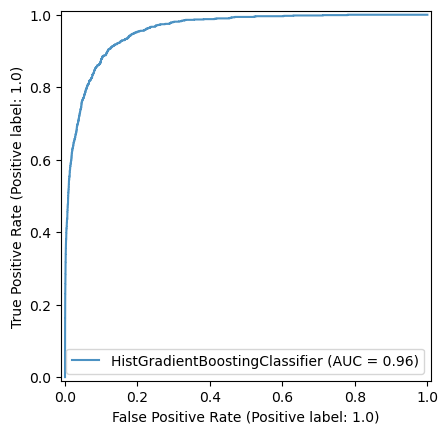

In [74]:
hgfc_params = {'min_samples_leaf': 20,
 'max_iter': 500,
 'max_depth': None,
 'max_bins': 200,
 'learning_rate': 0.3,
 'l2_regularization': 1.0,
 'categorical_features': None}

gfc = HistGradientBoostingClassifier(**hgfc_params)
gfc.fit(training_data_X, training_data_y)
ax = plt.gca()
gfc_disp = RocCurveDisplay.from_estimator(gfc, test_data_X, test_data_y, ax=ax, alpha=0.8)
plt.show()

In [76]:
len(training_data_X)

72284

In [79]:
len(validation_data_X)

23027

In [96]:
np.matrix(X)

matrix([[1.47826222e-02, 7.36174587e+00, 4.10265293e-02, ...,
         9.99000000e+02, 0.00000000e+00, 2.21373363e+01],
        [5.13013644e-03, 1.07732865e+00, 1.61721398e-02, ...,
         7.36558319e+00, 5.52216059e+00, 0.00000000e+00],
        [1.98455281e-02, 5.65597550e+00, 5.62984404e-02, ...,
         1.10983020e+01, 8.43067226e+00, 0.00000000e+00],
        ...,
        [4.41383241e-02, 2.10539806e+01, 1.12127206e-01, ...,
         0.00000000e+00, 0.00000000e+00, 1.67551893e+01],
        [3.63781204e-02, 8.83988325e+00, 9.66575492e-02, ...,
         0.00000000e+00, 0.00000000e+00, 1.20082475e+01],
        [1.61808043e-02, 1.31064515e+00, 5.08871459e-02, ...,
         0.00000000e+00, 0.00000000e+00, 2.22141285e+00]])

/tmp/ipykernel_1547462/1413691662.py:19: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_1547462/1413691662.py:19: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_1547462/1413691662.py:19: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_1547462/1413691662.py:19: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_1547462/1413691662.py:19: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_1547462/1413691662.py:19: Depr

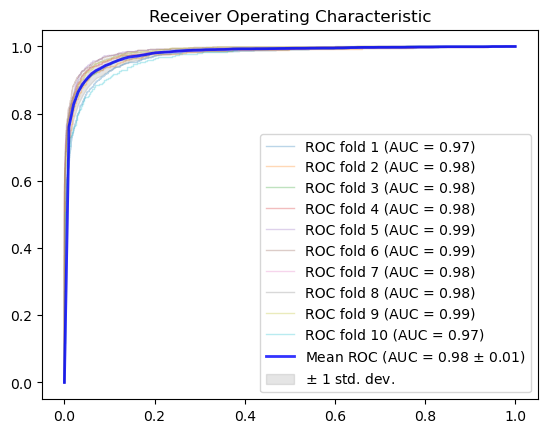

In [100]:
X = np.array(training_data_X)
y = np.array(training_data_y)

classifier = HistGradientBoostingClassifier()

# Define StratifiedKFold to maintain the proportion of each class
cv = StratifiedKFold(n_splits=10)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()

for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = roc_curve(y[test], classifier.predict_proba(X[test])[:, 1])
    fpr, tpr, thresholds = viz
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    ax.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {i+1} (AUC = {roc_auc:.2f})')

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver Operating Characteristic")
ax.legend(loc="lower right")
plt.show()

In [ ]:
feature_list = features["Gaertner"]
random.shuffle(feature_list)
model_Gaertner = run(feature_list)

In [ ]:
feature_list = features["iPSC"]
random.shuffle(feature_list)
model_iPSC = run(feature_list)

# Evaluate different models on the same test data

In [6]:
test_loss, roc_auc, pr_auc = modeling.evaluate_model(nn.BCELoss(), best_model, test_data_x, test_data_y)

NameError: name 'best_model' is not defined

In [ ]:
evaluate(model=model_Gaertner_iPSC,
         feature_list=features["MB1"],
         experiment_name="HCT116_model_pancreatic_progenitors_iPSC")

In [ ]:
evaluate(model=model_Gaertner,
         feature_list=features["MB1"],
         experiment_name="HCT116_model_pancreatic_progenitors")

In [ ]:
evaluate(model=model_iPSC,
         feature_list=features["MB1"],
         experiment_name="HCT116_model_iPSC")